In [153]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb

C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1.Load data

In [39]:
df_channel = pd.read_csv('orders_channels.csv')
df_country = pd.read_csv('orders_country.csv')
df_tickets = pd.read_csv('orders_tickets.csv')

## 2. Exploratory Data Analysis (EDA) 

In [40]:
df_channel.head()

,id,date,channel_id
0,10173,2017-06-12,39.0
1,95062,2017-09-11,35.0
2,171081,2017-07-05,39.0
3,122867,2017-08-18,39.0
4,107186,2017-11-23,NaN


In [41]:
df_channel.shape

(2054059, 3)

In [42]:
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054059 entries, 0 to 2054058
Data columns (total 3 columns):
id            int64
date          object
channel_id    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 47.0+ MB


In [86]:
df_channel['date'].isnull().sum()

0

In [43]:
df_channel['channel_id'].isnull().sum()

295625

In [44]:
df_channel['channel_id'].unique()

array([39., 35., nan, 28., 37., 40., 31., 49., 26., 29.,  2.,  1., 33.,
       17., 30., 25., 23., 38., 43., 36.,  5., 42., 41., 24.,  4., 27.,
       32., 47.,  8., 13.])

In [45]:
len(df_channel['channel_id'].unique())

30

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000005CE74048>]],
      dtype=object)

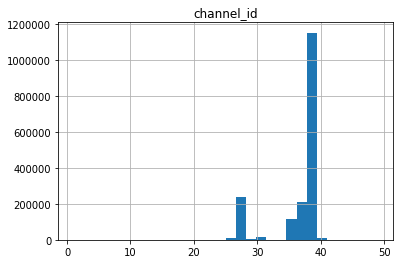

In [46]:
df_channel.hist(column='channel_id', bins=len(df_channel['channel_id'].unique()))

In [47]:
df_channel['date'] = pd.to_datetime(df_channel['date'])

In [48]:
df_country.head()

,id,country_1,country_2
0,10503,24.0,NaN
1,79360,24.0,0
2,81388,24.0,15
3,82828,24.0,9
4,38756,23.0,NaN


In [49]:
df_country.shape

(1917668, 3)

In [50]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917668 entries, 0 to 1917667
Data columns (total 3 columns):
id           int64
country_1    float64
country_2    object
dtypes: float64(1), int64(1), object(1)
memory usage: 43.9+ MB


In [51]:
df_country['country_1'].isnull().sum()

17831

In [52]:
df_country['country_2'].isnull().sum()

748932

In [53]:
df_country['country_1'].unique()

array([24., 23., 19., 11., 12.,  9.,  4., 29., 14.,  5., 20., 26., 27.,
        8., 21.,  7., 32., nan, 28., 17., 15., 31., 16., 22.])

In [54]:
df_country['country_2'].unique()

array([nan, '0', '15', '9', '13', '4', '2', '6', '17', '8', '14', '20',
       '16', '12', '3', '19', '18', '11', 'xx', '1', '7'], dtype=object)

In [28]:
#df_country.loc[(df_country['country_2']=='xx')] = '-1'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000103DBB38>]],
      dtype=object)

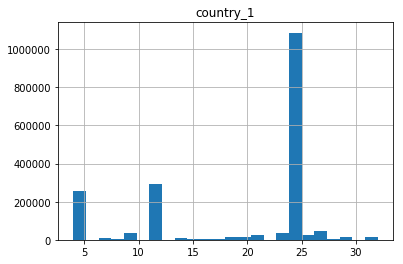

In [60]:
df_country.hist(column='country_1', bins=len(df_country['country_1'].unique()))

In [67]:
le = LabelEncoder()
le.fit(df_country['country_2'].tolist())

LabelEncoder()

In [69]:
df_country['country_2'] = le.transform(df_country['country_2'].tolist())

In [70]:
df_country['country_2'].unique()

array([19,  0,  6, 18,  4, 14, 11, 15,  8, 17,  5, 12,  7,  3, 13, 10,  9,
        2, 20,  1, 16], dtype=int64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001047B7F0>]],
      dtype=object)

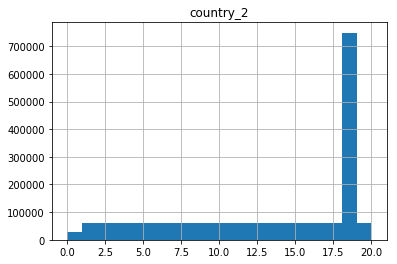

In [71]:
df_country.hist(column='country_2', bins=len(df_country['country_2'].unique()))

In [72]:
df_tickets.head()

,id,n_tickets,type
0,1586391,2,pax
1,438232,2,pax
2,270896,1,pax
3,1181593,2,pax
4,964842,1,pax


In [73]:
df_tickets.shape

(1999716, 3)

In [74]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999716 entries, 0 to 1999715
Data columns (total 3 columns):
id           int64
n_tickets    int64
type         object
dtypes: int64(2), object(1)
memory usage: 45.8+ MB


In [75]:
df_tickets['type'].unique()

array(['pax', 'other'], dtype=object)

In [76]:
df_tickets['n_tickets'].unique()

array([ 2,  1,  8,  4,  6,  5,  3, 12, 10,  7, 14, 20, 60,  9, 13, 11, 22,
       28, 15, 31, 40, 18, 24, 32, 26, 19, 16, 54, 44, 21, 23, 30, 56, 81,
       38, 52, 25, 17, 29, 34, 39, 49, 80, 66, 36, 42, 64, 27, 48, 46, 50,
       35, 41, 76, 70, 57, 58, 43, 45, 33, 68, 74, 67, 65, 47, 84, 37],
      dtype=int64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000105187F0>]],
      dtype=object)

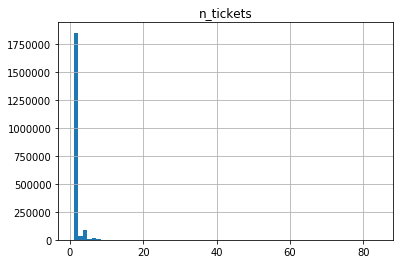

In [77]:
df_tickets.hist(column='n_tickets', bins=len(df_tickets['n_tickets'].unique()))

## 3. Data Preparation

In [98]:
df_merged = pd.merge(df_channel, df_tickets, how='left', on=['id'])
df_merged = pd.merge(df_merged, df_country, how='left', on=['id'])

In [99]:
df_merged['date'] = pd.to_datetime(df_merged['date'])

In [100]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084458 entries, 0 to 2084457
Data columns (total 7 columns):
id            int64
date          datetime64[ns]
channel_id    float64
n_tickets     int64
type          object
country_1     float64
country_2     float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 127.2+ MB


In [101]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2
0,10173,2017-06-12,39.0,2,pax,24.0,19.0
1,95062,2017-09-11,35.0,1,pax,12.0,19.0
2,171081,2017-07-05,39.0,1,pax,4.0,2.0
3,122867,2017-08-18,39.0,1,other,24.0,8.0
4,107186,2017-11-23,NaN,2,pax,12.0,12.0


#### some orders are assigned to two countries, with country_1 being more important. if there is no value in "country_1", use "country_2"

In [102]:
def f(x, y):
    if x is None:
        return y
    return x
               
df_merged['country'] = df_merged['country_1'].apply(f, args=[df_merged['country_2']])

In [103]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country
0,10173,2017-06-12,39.0,2,pax,24.0,19.0,24.0
1,95062,2017-09-11,35.0,1,pax,12.0,19.0,12.0
2,171081,2017-07-05,39.0,1,pax,4.0,2.0,4.0
3,122867,2017-08-18,39.0,1,other,24.0,8.0,24.0
4,107186,2017-11-23,NaN,2,pax,12.0,12.0,12.0


In [104]:
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['year'] = df_merged['date'].dt.year

In [105]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country,month,day,year
0,10173,2017-06-12,39.0,2,pax,24.0,19.0,24.0,6,12,2017
1,95062,2017-09-11,35.0,1,pax,12.0,19.0,12.0,9,11,2017
2,171081,2017-07-05,39.0,1,pax,4.0,2.0,4.0,7,5,2017
3,122867,2017-08-18,39.0,1,other,24.0,8.0,24.0,8,18,2017
4,107186,2017-11-23,NaN,2,pax,12.0,12.0,12.0,11,23,2017


In [106]:
df_merged.to_csv('df_merged.csv', index=False)

### Approach 1

- For each group (channel, country) train a regression model on the features (year, month, day) and label (number of tickets).
- For each group generate a test sample. The date of the test sample is the last date of the train sample in the sample group plus 10 days.
- Use the trained model to predict the label (number of tickets) of the test sample.


In [110]:
df_merged = pd.read_csv('df_merged.csv')
df_merged['date'] = pd.to_datetime(df_merged['date'])

In [111]:
df_merged_grouped = df_merged.groupby(['channel_id', 'country'])

In [112]:
dict_test = {'date':[], 'country':[], 'channel_id':[], 'n_tickets':[]}

for name,group in df_merged_grouped:
    group = group.sort_values(by=['date'])
    
    # for each group train a regression model
    # features are month and day, label is the number of tickets
    x_train = group[['year', 'month', 'day']]
    y_train = group[['n_tickets']]
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)

    model = Ridge()
    model.fit(x_train_scaled, y_train)
    
    date_test = group.iloc[-1]['date'] + pd.Timedelta(days=10)
    x_test = np.array([date_test.year, date_test.month, date_test.day]).reshape(1,3)
    x_test_scaled = scaler.transform(x_test)
    y_test = model.predict(x_test_scaled)

    # use the trained linear regression model to predict the number of the tickets in the 10 days after the end of the group
    dict_test['date'].append(date_test)
    dict_test['country'].append(group.iloc[0]['country'])
    dict_test['channel_id'].append(group.iloc[0]['channel_id'])
    if round(y_test[0][0]) < 0:
        y_test[0][0] = 0
    dict_test['n_tickets'].append(round(y_test[0][0]))


C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [113]:
df_test = pd.DataFrame(dict_test)

In [114]:
df_test

,date,country,channel_id,n_tickets
0,2018-03-06,4.0,1.0,2.0
1,2018-01-30,5.0,1.0,2.0
2,2018-01-13,7.0,1.0,1.0
3,2017-07-20,8.0,1.0,2.0
4,2018-02-17,9.0,1.0,1.0
5,2018-03-07,11.0,1.0,2.0
6,2018-02-12,12.0,1.0,2.0
7,2018-02-10,14.0,1.0,1.0
8,2018-01-13,15.0,1.0,2.0
9,2018-02-03,16.0,1.0,1.0


save prediction results to a csv

In [115]:
df_test.to_csv('pred_approach1_ridge.csv', index=False)

### Approach 2

- Train a regression model on all the data. The features are: date (year, month, day), channel, and country. The label is the number of tickets.
- For each group (channel, country), create a test sample as presented in Approach 1.
- Use the trained regression model to predict the number of tickets of all the test samples.

In [133]:
df_merged = pd.read_csv('df_merged.csv')
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084458 entries, 0 to 2084457
Data columns (total 11 columns):
id            int64
date          datetime64[ns]
channel_id    float64
n_tickets     int64
type          object
country_1     float64
country_2     float64
country       float64
month         int64
day           int64
year          int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 174.9+ MB


#### one-hot encoding on categorical features
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [134]:
cols_cat = ['channel_id', 'country']
for col_cat in cols_cat:
    one_hot = pd.get_dummies(df_merged[col_cat], prefix=col_cat)
    #df_merged = df_merged.drop(col_cat, axis = 1)
    df_merged = df_merged.join(one_hot)

In [135]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country,month,day,...,country_21.0,country_22.0,country_23.0,country_24.0,country_26.0,country_27.0,country_28.0,country_29.0,country_31.0,country_32.0
0,10173,2017-06-12,39.0,2,pax,24.0,19.0,24.0,6,12,...,0,0,0,1,0,0,0,0,0,0
1,95062,2017-09-11,35.0,1,pax,12.0,19.0,12.0,9,11,...,0,0,0,0,0,0,0,0,0,0
2,171081,2017-07-05,39.0,1,pax,4.0,2.0,4.0,7,5,...,0,0,0,0,0,0,0,0,0,0
3,122867,2017-08-18,39.0,1,other,24.0,8.0,24.0,8,18,...,0,0,0,1,0,0,0,0,0,0
4,107186,2017-11-23,NaN,2,pax,12.0,12.0,12.0,11,23,...,0,0,0,0,0,0,0,0,0,0


#### Prepare the training set

In [137]:
cols_feature = list(df_merged.columns) 
for col_remove in ['id', 'channel_id', 'country', 'date', 'n_tickets', 'type', 'country_1', 'country_2']:
    cols_feature.remove(col_remove)
cols_feature

['month',
 'day',
 'year',
 'channel_id_1.0',
 'channel_id_2.0',
 'channel_id_4.0',
 'channel_id_5.0',
 'channel_id_8.0',
 'channel_id_13.0',
 'channel_id_17.0',
 'channel_id_23.0',
 'channel_id_24.0',
 'channel_id_25.0',
 'channel_id_26.0',
 'channel_id_27.0',
 'channel_id_28.0',
 'channel_id_29.0',
 'channel_id_30.0',
 'channel_id_31.0',
 'channel_id_32.0',
 'channel_id_33.0',
 'channel_id_35.0',
 'channel_id_36.0',
 'channel_id_37.0',
 'channel_id_38.0',
 'channel_id_39.0',
 'channel_id_40.0',
 'channel_id_41.0',
 'channel_id_42.0',
 'channel_id_43.0',
 'channel_id_47.0',
 'channel_id_49.0',
 'country_4.0',
 'country_5.0',
 'country_7.0',
 'country_8.0',
 'country_9.0',
 'country_11.0',
 'country_12.0',
 'country_14.0',
 'country_15.0',
 'country_16.0',
 'country_17.0',
 'country_19.0',
 'country_20.0',
 'country_21.0',
 'country_22.0',
 'country_23.0',
 'country_24.0',
 'country_26.0',
 'country_27.0',
 'country_28.0',
 'country_29.0',
 'country_31.0',
 'country_32.0']

In [138]:
len(cols_feature)

55

In [139]:
x_train = df_merged[cols_feature]

In [140]:
x_train.shape

(2084458, 55)

In [141]:
y_train = df_merged[['n_tickets']]

In [142]:
y_train.shape

(2084458, 1)

#### Prepare the test set

In [143]:
df_merged_grouped = df_merged.groupby(['channel_id', 'country'])

In [146]:
dict_test = {'date':[], 'country':[], 'channel_id':[], 'n_tickets':[]}
for col_feature in cols_feature:
    dict_test[col_feature] = []

In [147]:
dict_test

{'date': [],
 'country': [],
 'channel_id': [],
 'n_tickets': [],
 'month': [],
 'day': [],
 'year': [],
 'channel_id_1.0': [],
 'channel_id_2.0': [],
 'channel_id_4.0': [],
 'channel_id_5.0': [],
 'channel_id_8.0': [],
 'channel_id_13.0': [],
 'channel_id_17.0': [],
 'channel_id_23.0': [],
 'channel_id_24.0': [],
 'channel_id_25.0': [],
 'channel_id_26.0': [],
 'channel_id_27.0': [],
 'channel_id_28.0': [],
 'channel_id_29.0': [],
 'channel_id_30.0': [],
 'channel_id_31.0': [],
 'channel_id_32.0': [],
 'channel_id_33.0': [],
 'channel_id_35.0': [],
 'channel_id_36.0': [],
 'channel_id_37.0': [],
 'channel_id_38.0': [],
 'channel_id_39.0': [],
 'channel_id_40.0': [],
 'channel_id_41.0': [],
 'channel_id_42.0': [],
 'channel_id_43.0': [],
 'channel_id_47.0': [],
 'channel_id_49.0': [],
 'country_4.0': [],
 'country_5.0': [],
 'country_7.0': [],
 'country_8.0': [],
 'country_9.0': [],
 'country_11.0': [],
 'country_12.0': [],
 'country_14.0': [],
 'country_15.0': [],
 'country_16.0': [],

In [148]:
for name,group in df_merged_grouped:
    group = group.sort_values(by=['date'])
    
    # get the last date of the group
    date_test = group.iloc[-1]['date'] + pd.Timedelta(days=10)

    # generate test sample
    dict_test['date'].append(date_test)
    dict_test['country'].append(group.iloc[0]['country'])
    dict_test['channel_id'].append(group.iloc[0]['channel_id'])
    dict_test['n_tickets'] = 0
    for col_feature in cols_feature:
        dict_test[col_feature].append(group.iloc[0][col_feature])
    
df_test = pd.DataFrame(dict_test)
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['year'] = df_test['date'].dt.year

In [149]:
x_test = df_test[cols_feature]

In [150]:
x_test.shape

(412, 55)

#### Check cross validation scores for different regression model
https://stackoverflow.com/questions/24132237/scikit-learn-cross-validation-scoring-for-regression

In [154]:
loo = cross_validation.LeaveOneOut(len(y_train))

In [ ]:
scores = cross_validation.cross_val_score(LinearRegression(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\an

C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\an

C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\an

C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Chen.Kai\an

In [ ]:
scores

In [ ]:
scores = cross_validation.cross_val_score(Lasso(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

In [ ]:
scores = cross_validation.cross_val_score(Ridge(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

#### Train a regression model with parameter tuning
https://stackoverflow.com/questions/49522928/cross-validation-in-linear-regression


In [ ]:
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('regr', Ridge())
])

param_grid = [
    {
        'regr': [Lasso(), Ridge()],
        'regr__alpha': np.logspace(-4, 1, 6),
    },
    {
        'regr': [SGDRegressor()],
        'regr__alpha': np.logspace(-5, 0, 6),
        'regr__max_iter': [500, 1000],
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(x_train, y_train)

predicted = grid.predict(X_test, y_test)

print('Score:\t{}'.format(grid.score(X_test, y_test)))

#### Try other regression models
https://gogul09.github.io/software/sklearn-regression-models

xgboost
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

## 3. Conclusion